In [3]:
import json
import matplotlib.pyplot as plt
import SimpleITK as sitk
import os
import time
import numpy as np

In [4]:
def dicom_metainfo(dicm_path, list_tag):
    '''
    获取dicom的元数据信息
    :param dicm_path: dicom文件地址
    :param list_tag: 标记名称列表,比如['0008|0018',]
    :return:
    '''
    reader = sitk.ImageFileReader()
    reader.LoadPrivateTagsOn()
    reader.SetFileName(dicm_path)
    reader.ReadImageInformation()
    return [reader.GetMetaData(t) for t in list_tag]


def dicom2array(dcm_path):
    '''
    读取dicom文件并把其转化为灰度图(np.array)
    https://simpleitk.readthedocs.io/en/master/link_DicomConvert_docs.html
    :param dcm_path: dicom文件
    :return:
    '''
    image_file_reader = sitk.ImageFileReader()
    image_file_reader.SetImageIO('GDCMImageIO')
    image_file_reader.SetFileName(dcm_path)
    image_file_reader.ReadImageInformation()
    image = image_file_reader.Execute()
    if image.GetNumberOfComponentsPerPixel() == 1:
        image = sitk.RescaleIntensity(image, 0, 255)
        if image_file_reader.GetMetaData('0028|0004').strip() == 'MONOCHROME1':
            image = sitk.InvertIntensity(image, maximum=255)
        image = sitk.Cast(image, sitk.sitkUInt8)
    img_x = sitk.GetArrayFromImage(image)[0]
    return img_x


def get_info(trainPath, jsonPath):
    annotation_info = pd.DataFrame(columns=('studyUid', 'seriesUid', 'instanceUid', 'annotation'))
    json_df = pd.read_json(jsonPath)
    for idx in json_df.index:
        studyUid = json_df.loc[idx, "studyUid"]
        seriesUid = json_df.loc[idx, "data"][0]['seriesUid']
        instanceUid = json_df.loc[idx, "data"][0]['instanceUid']
        annotation = json_df.loc[idx, "data"][0]['annotation']
        row = pd.Series(
            {'studyUid': studyUid, 'seriesUid': seriesUid, 'instanceUid': instanceUid, 'annotation': annotation})
        annotation_info = annotation_info.append(row, ignore_index=True)
    dcm_paths = glob.glob(os.path.join(trainPath, "**", "**.dcm"))  # 具体的图片路径
    # 'studyUid','seriesUid','instanceUid'
    tag_list = ['0020|000d', '0020|000e', '0008|0018']
    dcm_info = pd.DataFrame(columns=('dcmPath', 'studyUid', 'seriesUid', 'instanceUid'))
    for dcm_path in dcm_paths:
        try:
            studyUid, seriesUid, instanceUid = dicom_metainfo(dcm_path, tag_list)  # 获取当前图像的3个id，然后再与json中的对应
            row = pd.Series(
                {'dcmPath': dcm_path, 'studyUid': studyUid, 'seriesUid': seriesUid, 'instanceUid': instanceUid})
            dcm_info = dcm_info.append(row, ignore_index=True)
        except:
            continue
    result = pd.merge(annotation_info, dcm_info, on=['studyUid', 'seriesUid', 'instanceUid'])  # 两个pd根据3个id合并
    result = result.set_index('dcmPath')['annotation']  # 然后把index设置为路径，值设置为annotation
    return result


In [5]:
# 读取一个study下的所有图片
# study11 = []
# root = r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\data\train\study11'
# dirs = os.listdir(root)
# for dir in dirs:
#     dcm_dir = root + '\\' + dir
#     img_x = dicom2array(dcm_dir)
#     study11.append(img_x)
# print(len(study11))

In [6]:
# # 读取训练数据
# train = []
# root = r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\train\data'
# dirs = os.listdir(root)
# st = time.time()
# for dir in dirs:
#     dcm_dir = root + '\\' + dir
#     # dcm_dir = r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\train\study0'
#     reader = sitk.ImageSeriesReader()
#     seriesIDs = reader.GetGDCMSeriesIDs(dcm_dir)
#     dcm_series = reader.GetGDCMSeriesFileNames(dcm_dir, seriesIDs[0])
#     reader.SetFileNames(dcm_series)
#     img = reader.Execute()
#     img_arr = sitk.GetArrayFromImage(img)
#     origin = img.GetOrigin()
#     spacing = img.GetSpacing()
#     train.append(img)
# print('using time:{}'.format(time.time()-st))

In [7]:
# 读取标签json
t201 = json.load(open(r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\data\lumbar_train.json'))

# 保存结果json
# filename = r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\tmp\res.json'
# with open(filename, 'w') as file_obj:
#     json.dump(t201, file_obj)

In [11]:
t201[0]

{'studyUid': '1.3.6.1.4.1.96180.1.1.14710640.33760257.3274',
 'version': 'v0.1',
 'data': [{'seriesUid': '1.3.6.1.4.1.96180.1.1.14710640.33760257.3274.232780.2.3',
   'instanceUid': '1.3.6.1.4.1.96180.1.1.14710640.33760257.3274.232780.2.3.6',
   'annotation': [{'annotator': 72,
     'data': {'point': [{'tag': {'identification': 'L5', 'vertebra': 'v2'},
        'coord': [169, 252],
        'zIndex': 5},
       {'tag': {'identification': 'L4', 'vertebra': 'v2'},
        'coord': [169, 224],
        'zIndex': 5},
       {'tag': {'identification': 'L3', 'vertebra': 'v2'},
        'coord': [171, 194],
        'zIndex': 5},
       {'tag': {'identification': 'L2', 'vertebra': 'v2'},
        'coord': [172, 161],
        'zIndex': 5},
       {'tag': {'identification': 'L1', 'vertebra': 'v2'},
        'coord': [175, 126],
        'zIndex': 5},
       {'tag': {'identification': 'L5-S1', 'disc': 'v3'},
        'coord': [171, 270],
        'zIndex': 5},
       {'tag': {'identification': 'L4-L5', 'd

In [8]:
# data = t201[0]['data']
# # data[0].keys()
# seriesUid = data[0]['seriesUid']
# instanceUid = data[0]['instanceUid']
# annotation = data[0]['annotation']

In [9]:
# annotation
# len(annotation)
# annotation[0].keys()
# annotator = annotation[0]['annotator']
# annotation_data = annotation[0]['data']['point']
# annotation_data

In [10]:
# t201[0]
# t201[0]['data'][0]['annotation'][0]['data']['point']

In [11]:
# json_df.head()

In [12]:
# len(t51[0]['data'][0]['annotation'][0]['data']['point'])
# print(t51[0]['data'][0]['annotation'][0]['data']['point'])
tags = t201[0]['data'][0]['annotation'][0]['data']['point']
for tag in tags:
    print(tag)

{'tag': {'identification': 'L5', 'vertebra': 'v2'}, 'coord': [169, 252], 'zIndex': 5}
{'tag': {'identification': 'L4', 'vertebra': 'v2'}, 'coord': [169, 224], 'zIndex': 5}
{'tag': {'identification': 'L3', 'vertebra': 'v2'}, 'coord': [171, 194], 'zIndex': 5}
{'tag': {'identification': 'L2', 'vertebra': 'v2'}, 'coord': [172, 161], 'zIndex': 5}
{'tag': {'identification': 'L1', 'vertebra': 'v2'}, 'coord': [175, 126], 'zIndex': 5}
{'tag': {'identification': 'L5-S1', 'disc': 'v3'}, 'coord': [171, 270], 'zIndex': 5}
{'tag': {'identification': 'L4-L5', 'disc': 'v2'}, 'coord': [169, 238], 'zIndex': 5}
{'tag': {'identification': 'L3-L4', 'disc': 'v3'}, 'coord': [171, 209], 'zIndex': 5}
{'tag': {'identification': 'L2-L3', 'disc': 'v2'}, 'coord': [171, 175], 'zIndex': 5}
{'tag': {'identification': 'L1-L2', 'disc': 'v5'}, 'coord': [172, 145], 'zIndex': 5}
{'tag': {'identification': 'T12-L1', 'disc': 'v5'}, 'coord': [176, 108], 'zIndex': 5}


In [13]:
# data1 = train[0]
# img_arr = sitk.GetArrayFromImage(data1)  # 获取对应的array
# # img_arr.shape
# plt.imshow(img_arr[4, :, :], cmap='gray')

In [14]:
# img_arr.shape

In [16]:
from projectsLJN.jzjbycfg.utils import *
trainPath = r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\data\train' 
jsonPath = r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\data\lumbar_train.json'
st = time.time()
result = get_info(trainPath, jsonPath)
print(len(result))
print(result[0])
print('using time: {}'.format(time.time()-st))

201

[{'annotator': 72, 'data': {'point': [{'tag': {'identification': 'L5', 'vertebra': 'v2'}, 'coord': [169, 252], 'zIndex': 5}, {'tag': {'identification': 'L4', 'vertebra': 'v2'}, 'coord': [169, 224], 'zIndex': 5}, {'tag': {'identification': 'L3', 'vertebra': 'v2'}, 'coord': [171, 194], 'zIndex': 5}, {'tag': {'identification': 'L2', 'vertebra': 'v2'}, 'coord': [172, 161], 'zIndex': 5}, {'tag': {'identification': 'L1', 'vertebra': 'v2'}, 'coord': [175, 126], 'zIndex': 5}, {'tag': {'identification': 'L5-S1', 'disc': 'v3'}, 'coord': [171, 270], 'zIndex': 5}, {'tag': {'identification': 'L4-L5', 'disc': 'v2'}, 'coord': [169, 238], 'zIndex': 5}, {'tag': {'identification': 'L3-L4', 'disc': 'v3'}, 'coord': [171, 209], 'zIndex': 5}, {'tag': {'identification': 'L2-L3', 'disc': 'v2'}, 'coord': [171, 175], 'zIndex': 5}, {'tag': {'identification': 'L1-L2', 'disc': 'v5'}, 'coord': [172, 145], 'zIndex': 5}, {'tag': {'identification': 'T12-L1', 'disc': 'v5'}, 'coord': [176, 108], 'zIndex': 5}]}}]

using time: 65.2092924118042

In [38]:
from projectsLJN.jzjbycfg.utils import *

In [17]:
# # 验证一下是不是InstanceNumber这个对应zIndex
# import pydicom
# # dcmPaths = list(result.index)
# # for p in dcmPaths:
# #     print(p,'\t', pydicom.read_file(p).InstanceNumber)
# # 验证一个study中的每个dcm的InstanceNumber
# InstanceNumber = []
# root = r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\data\train\study0'
# dirs = os.listdir(root)
# for dir in dirs:
#     dcm_dir = root + '\\' + dir
#     InstanceNumber.append([dir, pydicom.read_file(dcm_dir).InstanceNumber])  # 获取该dcm图片的InstanceNumber
# InstanceNumber[:3]

In [18]:
from projectsLJN.jzjbycfg.utils import *
# 数据预处理之提取分类图片及标签
# trainPath = r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\data\train'
# jsonPath = r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\data\lumbar_train.json'
# res = get_info(trainPath, jsonPath)  # 获取图片路径及对应的annotation
res = result

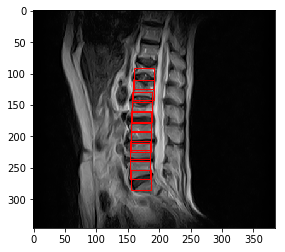

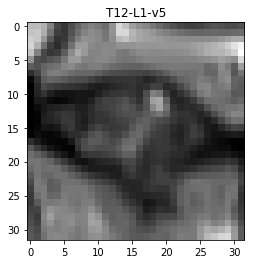

In [19]:
res[0]
img_dir = res.index[0]  # 获取图片的地址
img_arr = dicom2array(img_dir)  # 获取具体的图片数据，二维数据
tags = res[0][0]['data']['point']  # 获取图片的标签
tag = tags[0]  # 获取第一个标签
coord = tag['coord']  # 获取这个标签所在的坐标
# 显示图片
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# 把这个图片中的所有tags都加上去
for tag in tags:
    coord = tag['coord']
    top_left_x, top_left_y = coord[0]-16, coord[1]-16
    width, height = 32, 32  # 使目标点在正中间
    rect = plt.Rectangle((top_left_x, top_left_y), width, height, fill=False, edgecolor='red', linewidth=1)
    ax.add_patch(rect)  # https://blog.csdn.net/weixin_43486780/java/article/details/105741382
plt.imshow(img_arr, cmap='gray')
# 需要把每个方框中的小patch提取出来，以及对应的label
top_left_x, top_left_y = coord[0]-16, coord[1]-16
width, height = 32, 32  # 使目标点在正中间
patch = img_arr[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
label = '-'.join(list(tag['tag'].values()))  # 这样label也是唯一知道的了，能够分清是disc(椎间盘)和vertebra(椎体)就行
plt.figure(), plt.imshow(patch, cmap='gray'), plt.title(label)  # 正常提取出来了

In [25]:
def get_sample(res):
    samples = []
    for i in range(len(res)):
        img_dir = res.index[0]  # 获取图片的地址
        img_arr = dicom2array(img_dir)  # 获取具体的图片数据，二维数据
        tags = res[0][0]['data']['point']  # 获取图片的标签
        for tag in tags:
            coord = tag['coord']  # 获取这个标签所在的坐标
            # 需要把每个方框中的小patch提取出来，以及对应的label
            top_left_x, top_left_y = coord[0]-16, coord[1]-16
            width, height = 32, 32  # 使目标点在正中间
            patch = img_arr[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
            # label = '-'.join(list(tag['tag'].values()))  # 这样label也是唯一知道的了，能够分清是disc(椎间盘)和vertebra(椎体)就行
            dic = tag['tag']
            label = list(dic.keys())[-1]+'-'+list(dic.values())[-1]
            samples.append((patch, label))
    return samples

In [26]:
samples = get_sample(res)  # 总共能获取201*11=2211个sample
len(samples)
# res[0]

2211

In [27]:
class MyDataset(Dataset):
    # 需要自己写一个Dataset类，并且要继承从torch中import的Dataset基类，然后重写__len__和__getitem__两个方法，否则会报错
    # 此外还需要写__init__，传入数据所在路径和transform(用于数据预处理)
    def __init__(self, data_dir, transform=None):
        """
        :param data_dir: 读取的数据所在的路径
        :param transform: 数据预处理参数
        """
        self.label_name = {'vertebra-v1': 0, 'vertebra-v2': 1, 'disc-v1': 2, 'disc-v2': 3, 'disc-v3': 4, 'disc-v4': 5, 'disc-v5': 6}
        self.data_info = self.dataInfo(data_dir)  # 用来读取数据信息(数据路径，标签)
        self.transform = transform

    def __getitem__(self, index):  # 根据索引读取数据路径再读取数据
        img, label = self.data_info[index]
        img = Image.fromarray(img)
        label = self.label_name[label]  # 字符串转化为数字，注意后面各类可能还会存在类别不平衡问题

        if self.transform is not None:
            img = self.transform(img)
        else:  # 避免未作transforms而忘记把图像数据转化为tensor
            img = torch.tensor(img)
        return img, label

    def unpickle(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict

    def __len__(self):
        return len(self.data_info)

    @staticmethod
    def dataInfo(data_dir):  # 自定义函数用来获取数据信息，输入为数据所在路径，返回为一个元组(图像路径，标签路径)
        # 先读取所有的图像数据路径
        # data_info = os.listdir(data_dir)  # 读取该路径下的所有文件，此处的data_dir就是train文件夹所对应的路径
        # for i in range(len(data_info)):
        #     data_info[i] = os.path.join(data_dir, data_info[i])
        data_info = data_dir  # 由于传入的直接是数据，所以直接返回就行了，返回的是(图像数据，标签)
        return data_info  # 返回的是一个batch_size的数据路径

In [28]:
for i, item in enumerate(samples):
    print(item[1])
    if i > 10:
        break
# 构建DataLoader
Batch_size = 8
train_transform = transforms.Compose([transforms.Resize((32, 32)),  # 这里必须要把图像尺寸Resize，否则会出现数据维度不匹配问题
                                      transforms.ToTensor(), ])
train_data = MyDataset(data_dir=samples, transform=train_transform)
train_data_loader = DataLoader(dataset=train_data, batch_size=Batch_size, shuffle=True)

vertebra-v2

vertebra-v2

vertebra-v2

vertebra-v2

vertebra-v2

disc-v3

disc-v2

In [29]:
for iter, (inputs, labels) in enumerate(train_data_loader):
    print('input,' '\n', labels)
    if iter > 2:
        break
print(iter)

input,


tensor([4, 3, 6, 1, 3, 1, 1, 4])

input,


tensor([3, 4, 1, 6, 1, 1, 4, 4])

input,


tensor([1, 4, 3, 1, 3, 6, 3, 4])

input,


tensor([4, 3, 1, 1, 1, 1, 1, 3])

In [30]:
inputs.shape

torch.Size([8, 1, 32, 32])

In [57]:
from projectsLJN.jzjbycfg.utils import *

In [58]:
# model = models.resnet18(pretrained=True)  # 从torch模型库中直接加载已有的模型
model = ResNet(ResidualBlock, num_classes=10, in_channels=1)

NameError: name 'ResNet' is not defined

In [55]:
# 对于模型的每个权重，使其不进行反向传播，即固定参数
for param in model.parameters():
    param.requires_grad = False
# 但是参数全部固定了，也没法进行学习，所以我们不固定最后一层，即全连接层fc
for param in model.fc.parameters():
    param.requires_grad = True

class_num = 7  # 假设要分类数目是7
channel_in = model.fc.in_features  # 获取fc层的输入通道数
# 然后把resnet-101的fc层替换成300类别的fc层
model.fc = nn.Linear(channel_in, class_num)

In [56]:
outputs = model.forward(inputs)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[8, 1, 32, 32] to have 3 channels, but got 1 channels instead

In [33]:
# import numpy as np
samplesArr = np.array(samples)

In [38]:
print(set(samplesArr[:, 1]))
# for i, item in enumerate(samples):
#     print(item[1])
#     if i > 50:
#         break
# samplesArr[:10, :]

array([[array([[ 28,  31,  34, ...,  22,  20,  21],
       [ 37,  37,  37, ...,  12,   8,   4],
       [ 35,  34,  33, ...,   7,   6,   3],
       ...,
       [ 89, 115, 106, ...,  40,  42,  39],
       [ 89, 120, 109, ...,  38,  37,  30],
       [ 79, 117, 108, ...,  36,  33,  31]], dtype=uint8),
        'vertebra-v2'],
       [array([[17, 27, 33, ..., 31, 29, 29],
       [28, 21, 21, ..., 28, 28, 28],
       [42, 34, 28, ..., 32, 33, 34],
       ...,
       [37, 37, 37, ..., 12,  8,  4],
       [35, 34, 33, ...,  7,  6,  3],
       [28, 29, 32, ..., 17, 18, 18]], dtype=uint8),
        'vertebra-v2'],
       [array([[60, 58, 42, ..., 37, 37, 38],
       [68, 63, 46, ..., 50, 56, 61],
       [76, 64, 52, ..., 71, 78, 81],
       ...,
       [50, 40, 32, ..., 22, 22, 21],
       [33, 30, 22, ..., 29, 29, 26],
       [21, 24, 23, ..., 28, 27, 26]], dtype=uint8),
        'vertebra-v2'],
       [array([[ 75,  73,  71, ...,  34,  33,  26],
       [ 79,  85,  83, ...,  23,  32,  38],
       

In [59]:
import pickle


def save_obj(obj, name):  # 保存dict
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_obj(name):  # 加载dict
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [60]:
save_obj(samples, r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\tmp\samples')

In [61]:
smp = load_obj(r'C:\Users\Administrator\Desktop\2020spring\projectsLJN\jzjbycfg\tmp\samples')

In [62]:
smp[0]

(array([[ 28,  31,  34, ...,  22,  20,  21],
        [ 37,  37,  37, ...,  12,   8,   4],
        [ 35,  34,  33, ...,   7,   6,   3],
        ...,
        [ 89, 115, 106, ...,  40,  42,  39],
        [ 89, 120, 109, ...,  38,  37,  30],
        [ 79, 117, 108, ...,  36,  33,  31]], dtype=uint8), 'vertebra-v2')